# KEN3450, Data Analysis, Spring 2020

### Clinic 3: Classification in Python

**Add your name and i-number here and any other disclaimer info.**

**Check the honor policy code posted on the portal before reusing code you found online**

***
### Learning Goals:

By the end of this clinic, you should be able to:

* Run Classification Models (Logistic Regression, Decision Trees, Random Forests, etc.) in Python
* Explain and tackle issues like missing values or class inbalance in your dataset
* Judge the results of a classification model using AUROC scores
* Select a proper algorithm that works well with your data using techniques (see also last week) like:
    * Cross Validation
    * Regularization

***

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
%matplotlib inline
import seaborn as sns
sns.set()

## Part 1: Determine the Inbalance (Asymmetry)

First, we would like to notice in our data that they are highly unbalanced (assymetric). Load the data which should contain 9 columns (`health`, `age`, `sex`, `educ`, `sexornt`, `partyid`, `race`, `married`, `income`). `Age`, `educ` (how many years of education a person has) and `income` are quantitative, the others are qualitative.

In [2]:
gssdata=pd.read_csv("gssdata4.csv")
gssdata.head()

,health,age,sex,educ,sexornt,partyid,race,married,income
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN


Our goal is to predict if a person is in poor health or not. Let's create some dummy variables in order to measure that.

In [3]:
poorhealth = np.where(gssdata['health'] == 'poor',1,0)
excellenthealth = np.where(gssdata['health'] == 'excellent',1,0)
fairhealth = np.where(gssdata['health'] == 'fair',1,0)
gssdata['poorhealth'] = poorhealth
gssdata['fairhealth'] = fairhealth
gssdata['excellenthealth'] = excellenthealth

In [4]:
gssdata.describe()

,age,educ,married,income,poorhealth,fairhealth,excellenthealth
count,1551.000000,1551.000000,1551.000000,963.000000,1551.000000,1551.000000,1551.000000
mean,48.172792,13.803353,0.732431,15633.177570,0.063830,0.194068,0.266925
std,17.051151,3.011700,0.442835,5064.191118,0.244528,0.395609,0.442495
min,18.000000,0.000000,0.000000,500.000000,0.000000,0.000000,0.000000
25%,33.500000,12.000000,0.000000,13750.000000,0.000000,0.000000,0.000000
50%,48.000000,14.000000,1.000000,18750.000000,0.000000,0.000000,0.000000
75%,61.000000,16.000000,1.000000,18750.000000,0.000000,0.000000,1.000000
max,89.000000,20.000000,1.000000,18750.000000,1.000000,1.000000,1.000000


In order to make the task easier, we will consider it as a binary classification problem, where we are actually interested into predicting the people that are in poor health (class `poorhealth`) vs. the others (classes `fairhealth` and `excellenthealth` combined).

In [5]:
gssdata["poorhealth"].value_counts()/gssdata.shape[0]

0    0.93617
1    0.06383
Name: poorhealth, dtype: float64

Only 6% of the cases are in poor health, thus the majority class is "not poor health" and the minority class is "poor health". The accuracy of a classifier that predicts everybody NOT being in poor health would be than 93.6%. This shows why accuracy is not a good metric here - the obtained accuracy is high, however the model is very primitive and misclassifies all positive examples.

## Part 2: Fit a logistic model ignoring missing values

Let's begin by fitting a logistic regression model to predict poor health based on several of the other predictors in the model. In part 3, you will be asked to regularize (with cross-validation) to make sure you do not overfit, but for this part, we will keep things simple.

First, we need to do a small amount of data clean-up (ignoring missingness for now in `income`). Best practice would be to split into train/test first before looking at the data, but again, we can keep it simple in this part.

In [6]:
#creating dummies two ways
gssdata['female'] = 1*(gssdata['sex'] ==  'female')
dummy_vars = pd.get_dummies(gssdata[['sexornt','partyid','race']])
gssdata = gssdata.join(dummy_vars)

In [7]:
#Let's get a sense of the data we have
print(gssdata.shape)
gssdata.head()

(1551, 23)


,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,0,0,1,0,0,0,1,0,0,1
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,0,0,1,0,0,0,1,0,0,1
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN,0,...,0,0,1,0,0,0,1,0,0,1
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN,0,...,0,0,1,0,0,1,0,0,0,1
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN,1,...,0,0,1,0,0,1,0,0,0,1


In [8]:

# have to drop income because NaNs cause exceptions
X = gssdata[['age','educ','female','partyid_dem','partyid_rep']]
y = gssdata["poorhealth"]

In [10]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1000000)
logreg.fit(X,y)
print("Accuracy with out train-test split",logreg.score(X,y))


Accuracy with out train-test split 0.9368149580915538


D:\Blazej\Programs\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


---

## 2a: Handling missingness approach \#1: remove observations. 

We do not know how sklearn will treat the missing values (the `NaN`s), so we should do handle them ourselves.  As a base case, let's remove all observations with missingness.

In [11]:
##In the code below: Remove all observations that are not complete
##Report on how many samples were dropped.
print("# observations before:",gssdata.shape[0])
gssdata_full = gssdata.dropna()
print("# observations after:",gssdata_full.shape[0])

# observations before: 1551
# observations after: 963


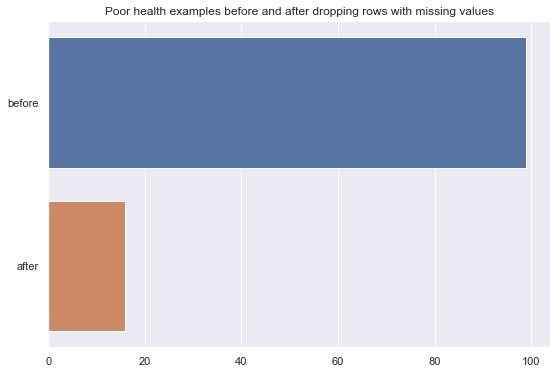

Poor health examples
Before: 99, after: 16


In [16]:
#Do a quick check to see how dropping observations affected the amount of poor health individuals
#Do an appropriate plot to show this (e.g. boxplot)
x = [gssdata[gssdata['poorhealth']==1].shape[0],gssdata_full[gssdata_full['poorhealth']==1].shape[0]]

plt.figure(figsize=(9,6))
plt.title("Poor health examples before and after dropping rows with missing values")

sns.barplot(x=x,y=['before','after'])
plt.show()
print("Poor health examples")
print("Before: {}, after: {}".format(x[0],x[1]))

In [21]:
#Now we will split the data before fitting any models, this way of splitting is much more elegant for me.

from sklearn.model_selection import train_test_split
X = gssdata_full[['age','educ','female','partyid_dem','partyid_rep','income']]
y = gssdata_full['poorhealth']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [22]:
y_train.shape, X_train.shape, y_test.shape, X_test.shape

((722,), (722, 6), (241,), (241, 6))

In [24]:
#####################
# Your code here: fit a logistic model with C=1000000 and evaluate classification accuracy on the test set.
# Then move below to be reminded on the confusion matrix
#####################
logit = LogisticRegression(C=1000000)
logit.fit(X_train,y_train)
print("Accuracy without train-test split",logit.score(X_test,y_test))

Accuracy without train-test split 0.979253112033195


D:\Blazej\Programs\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Reminder: The Confusion Matrix & Some Useful Functions

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![confusionmatrix](./confusionmatrix_360.png)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`



[[236   0]
 [  5   0]]


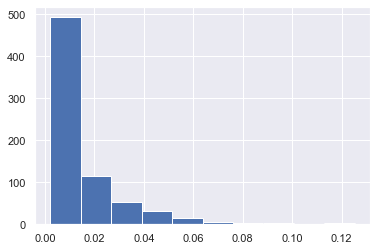

In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,logit.predict(X_test)))

yhats = logit.predict_proba(X_train)
hist = plt.hist(yhats[:,1])

The following function can be used to create confusion tables with different thresholds (same as we did in the last example of the lecture slides)

In [26]:
###manually making confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [27]:
#Try it here!

print(confusion_matrix(y_test,t_repredict(logit, 0.06, X_test)))
print(confusion_matrix(y_train,t_repredict(logit, 0.06, X_train)))

[[226  10]
 [  5   0]]
[[692  19]
 [ 11   0]]


The following fuction should create ROC curves for your models, based on the model and the ground truth. Feel free to change it and improve it!

In [43]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc

#name: name of your model to appear on the figure (can be arbitrary)
#clf: the model as you named it - will be used for getting the predictions
#ytest, xtest: your test data
#skip, labe: steps that control how many points you see in the ROC curve and how many labels are there

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    plt.figure(figsize=(15,10))
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM? (but double-check this pleaseee)
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    
    #this is the single value for the AUC score
    roc_auc = auc(fpr, tpr)
    
    if skip: 
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    
    #add labels to the curve
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

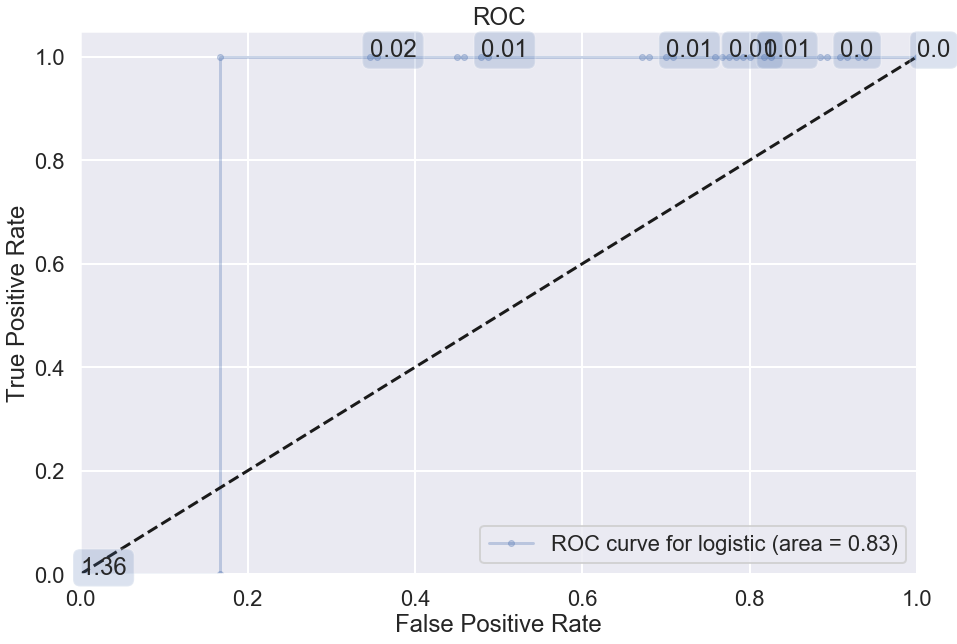

In [44]:
#This is how the above function should be used

sns.set_context("poster")
ax=make_roc("logistic",logit, y_test, X_test, labe=4, skip=0)

## Let's get back the data with missingness

It's time to build a model to impute the missing data!

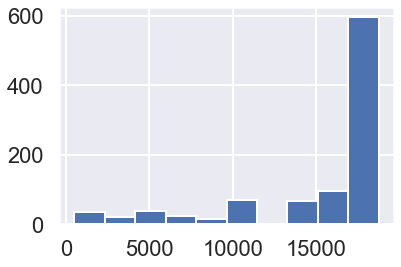

In [30]:
#first build a model to impute using data without missing 
hist = plt.hist(gssdata_full['income'])

---

## 2b: Handling missingness approach \#2: impute the mean 

In your first approach, make a copy of the original data frame and impute the missing values by assuming that every missing value shoudl be replaced by the mean. Make sure to do a histogram as well and compare it with the original!

Then fit a model (as before in 2a.) and judge the model accuracy. Use the functions for the ROC curve to establish the result.

In [87]:
#back to the original data set with missingness, make a copy, and then impute the mean, plot it!
mean_income = gssdata['income'].mean()
gssdata_full = gssdata.copy()
gssdata_full['income'] = gssdata_full['income'].fillna(mean_income)

In [37]:
###here, do a proper train/test split and a model training
X = gssdata_full[['age','educ','female','partyid_dem','partyid_rep','income']]
y = gssdata_full['poorhealth']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

logit = LogisticRegression(C=1000000)
logit.fit(X_train,y_train)

D:\Blazej\Programs\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
#####################
#your code here: create confusion tables for some thresholds to have an idea of how data looks like
#####################
thresholds = [0.01, 0.06, 0.12, 0.2]
for thresh in thresholds:
    print(confusion_matrix(y_test,t_repredict(logit, thresh, X_test)))
    print()


[[103 137]
 [  0   1]]

[[219  21]
 [  1   0]]

[[235   5]
 [  1   0]]

[[239   1]
 [  1   0]]



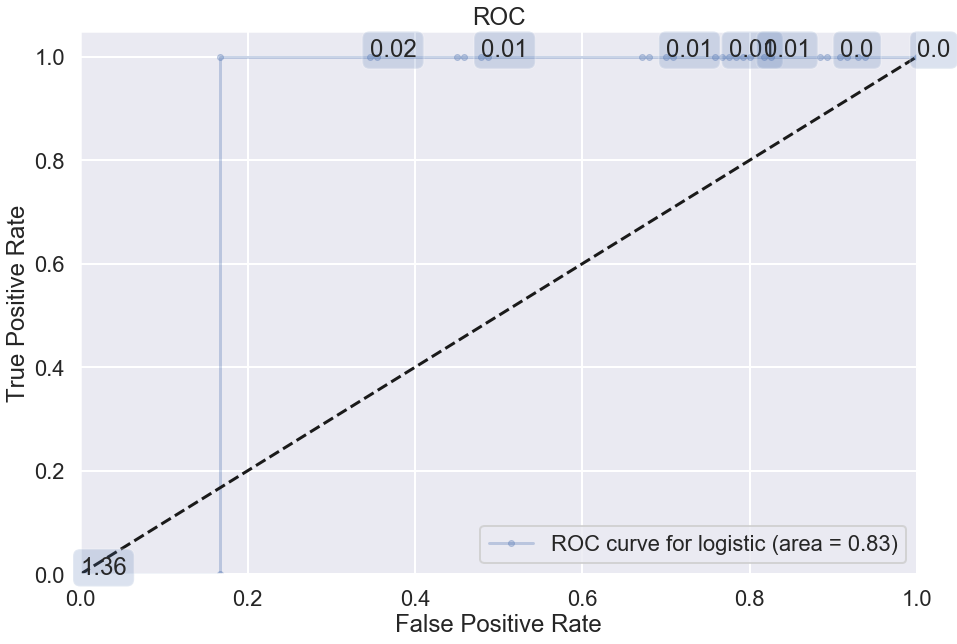

In [45]:
#####################
# your code here: create an ROC curve
#####################

sns.set_context("poster")
ax=make_roc("logistic",logit, y_test, X_test, labe=4, skip=0)

You will comment on the performance of the models in the end, but feel free to add any comments here as well (or remove this cell)

---

## 2c: Handling missingness approach \#3: impute with a model (linear regression here)

The third and most sophisticated approach would be to fit a linear model (multiple regression) to estimate income based on the other features (`age`, `educ`, `sex`, `partyid`). Train this model below and then use it in order to compute the missing values.

In [6]:
#use the dataset without NAs here
#train a model

In [8]:
#####################
# your code here: 
# 1. figure out which observations have missing values for income,
# 2. create the values you will use for imputation by:
#  - calculating (1) the predicted values for the observations with missingness using the linear model 
# 3. use these values to impute back into the income variable in the missing entries
# 4. Do a histogram to see how does that look like
#####################


Then fill the missing data with the results you got. You can do that multiple ways, one way to use Python would be the following:

In [ ]:
#you might need to change some of the variables below, but in principle it should work
missing_index = gssdata.income[gssdata.income.isnull()].index
missing_series = pd.Series(data = y_missing_noise, index = missing_index)
#back to the data set with missingness and impute the predictions
gssdata_imp = gssdata.copy()
gssdata_imp['income'] = gssdata_imp['income'].fillna(missing_series)

In [9]:
#HERE FIT YOUR MODEL AS USUAL FOR PREDICTING THE HEALTH STATUS (POOR OR NOT)

In [10]:
#MAKE CONFUSION TABLES FOR DIFFERENT THRESHOLDS AND DRAW THE AUROC CURVE

Which model performs the best when it comes to missing values? Use this cell to report your observations and be critical about them.

## Part 3: Improving the model.

Apply regularization (with cross-validation) to make sure not to overfit to the data and try also different models, like a Decision Tree or a Random Forest. Report on your results for which model handles inbalances in the best way.

In [ ]:
####YOUR CODE HERE

Your comments go here. Make sure you document and comment on each step of your approach. Also, make sure that you sufficiently comment on the results and be critical. Which approach worked the best? How did they handle missingness?